In [1]:
import copy
import numpy
import pandas

import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [2]:
df_pre_2021 = pandas.read_excel('data/Wansted 15min Rainfall Data 1991_2020.xlsx', skiprows=20)

In [3]:
df_pre_2021.head()

,Time stamp,Value[mm],State of value,Interpolation,Tags,Comments
0,1991-06-01 09:15:00,0,G,101,NaN,NaN
1,1991-06-01 09:30:00,0,G,101,NaN,NaN
2,1991-06-01 09:45:00,0,G,101,NaN,NaN
3,1991-06-01 10:00:00,0,G,101,NaN,NaN
4,1991-06-01 10:15:00,0,G,101,NaN,NaN


In [4]:
df_2021 = pandas.read_excel('data/Wansted 15min Rainfall Data 2021.xlsx', skiprows=20)

In [5]:
df_2021.tail()

,Time stamp,Value[mm],State of value,Interpolation,Tags,Comments
29371,2021-11-02 22:45:00,0,U,101,NaN,NaN
29372,2021-11-02 23:00:00,0,U,101,NaN,NaN
29373,2021-11-02 23:15:00,0,U,101,NaN,NaN
29374,2021-11-02 23:30:00,0,U,101,NaN,NaN
29375,2021-11-02 23:45:00,0,U,101,NaN,NaN


In [6]:
df_post_2021 = pandas.read_csv('data/Wanstead Rainfall 2021.csv')

In [7]:
df_post_2021

,Unnamed: 0,Time stamp,Value[mm]
0,3541,2021-11-03T19:45:00Z,0.0
1,6928,2021-11-03T00:00:00Z,0.0
2,9161,2021-11-03T00:15:00Z,0.0
3,11509,2021-11-03T00:30:00Z,0.0
4,13951,2021-11-03T00:45:00Z,0.0
...,...,...,...
28366,381828,2022-08-25T22:45:00Z,0.0
28367,383702,2022-08-25T23:00:00Z,0.0
28368,389351,2022-08-25T23:15:00Z,0.0
28369,392539,2022-08-25T23:30:00Z,0.0


Merge data from different time periods

In [8]:
df_merged = (
    # Concatenate dataframes
    pandas.concat([df_pre_2021, df_2021, df_post_2021], axis=0)
    .rename(columns={'Time stamp': 'Timestamp', 'Value[mm]': 'Rainfall'})
    .assign(
        Timestamp=lambda x: pandas.to_datetime(x['Timestamp']),
        # Replace --- with zero
        Rainfall=lambda x: x['Rainfall'].replace({'---': 0}).astype(float)
    )
    .filter(items=['Timestamp', 'Rainfall'])
)

In [9]:
df_merged.head()

,Timestamp,Rainfall
0,1991-06-01 09:15:00+00:00,0.0
1,1991-06-01 09:30:00+00:00,0.0
2,1991-06-01 09:45:00+00:00,0.0
3,1991-06-01 10:00:00+00:00,0.0
4,1991-06-01 10:15:00+00:00,0.0


### Daily Rainfall

Aggregate to daily frequency

In [10]:
df_daily = (
    df_merged
    .groupby(by=pandas.Grouper(key='Timestamp', freq='D'))
    .agg({'Rainfall': 'sum'})
)

#### Time-series of daily rainfall

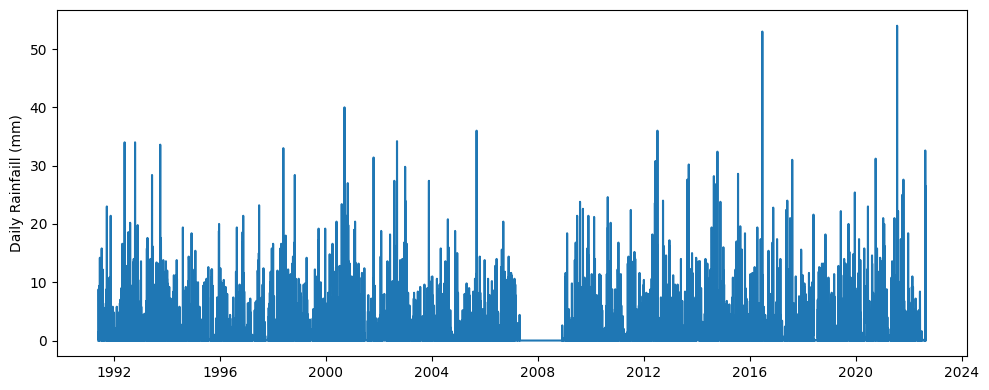

In [11]:
f, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(df_daily.index, df_daily['Rainfall'])

ax.set_ylabel('Daily Rainfaill (mm)')

plt.tight_layout()

There is a gap due to the site being offline whilst site works were completed (from FOI request).

#### Days with most rainfall

In [12]:
(
    df_daily
    .sort_values(by='Rainfall', ascending=False)
    .head(10)
)

,Rainfall
Timestamp,
2021-07-25 00:00:00+00:00,54.0
2016-06-23 00:00:00+00:00,53.0
2000-09-15 00:00:00+00:00,40.0
2005-09-10 00:00:00+00:00,36.0
2012-07-08 00:00:00+00:00,36.0
2002-09-09 00:00:00+00:00,34.2
1992-10-20 00:00:00+00:00,34.0
1992-05-29 00:00:00+00:00,34.0
1993-10-02 00:00:00+00:00,33.6


#### Number of occurences above a certain threshold

In [13]:
pandas.DataFrame(
    {'Threshold': threshold, 'NEvents': len(df_daily.loc[lambda x: x['Rainfall'] > threshold])}
    for threshold in [15, 20, 25, 30, 35, 40, 45, 50]
).set_index(keys=['Threshold'])

,NEvents
Threshold,
15,149
20,68
25,31
30,17
35,5
40,2
45,2
50,2


There were 15 days where there was more than 30mm of rainfall

#### Distribution of events

Approx. 30 year period, let's consider the probability of rainfall exceeding a value $X$, i.e., survival function but instead of considering survival past a given duration we consider rainfall greater than a certain amount

#### Fit survival function

In [14]:
from lifelines import KaplanMeierFitter, ExponentialFitter, NelsonAalenFitter

In [15]:
# No events are censored
df_daily['Observed'] = 1

obs = df_daily['Rainfall'].values
event = df_daily['Observed'].values

In [16]:
kmf = KaplanMeierFitter().fit(obs, event)

Text(0.5, 0, 'Daily Rainfall (mm)')

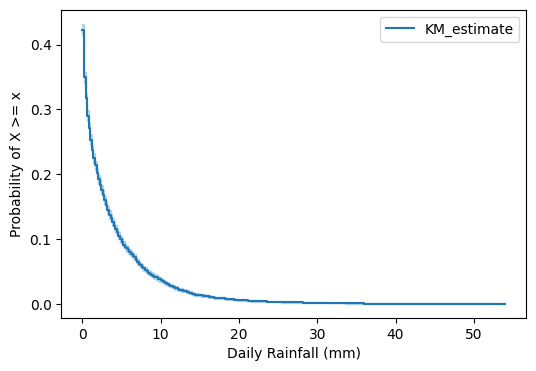

In [17]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))

kmf.plot_survival_function(ax=ax)

ax.set_ylabel('Probability of X >= x')
ax.set_xlabel('Daily Rainfall (mm)')

Invert probability to frequency of event

In [18]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,0.423350
0.2,0.349636
0.4,0.316943
0.6,0.314664
0.6,0.290297
...,...
34.2,0.000438
36.0,0.000263
40.0,0.000175


Text(0.5, 0, 'Daily Rainfall (mm)')

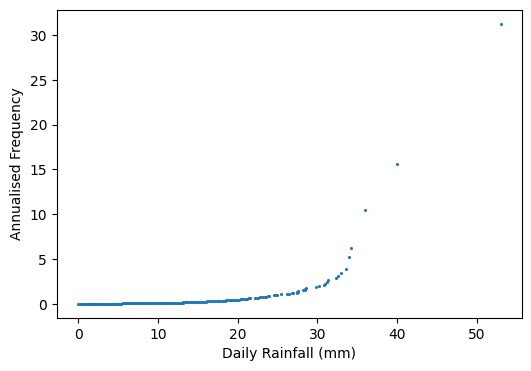

In [19]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))

surv_freq = (
    kmf.survival_function_
    .reset_index()
    .assign(
        test=1,
        freq=lambda x: (x['KM_estimate'] ** (-1)) / 365
    )
    .replace({numpy.inf: numpy.nan})
    .dropna()
)

surv_freq.plot(
    ax=ax,
    kind='scatter',
    x='timeline',
    y='freq',
    s=1.5)

ax.set_ylabel('Annualised Frequency')
ax.set_xlabel('Daily Rainfall (mm)')

In [20]:
(
    surv_freq
    .rename(columns={'timeline': 'rainfall'})
    .set_index(keys=['rainfall'])
    .filter(items=['freq'])
    .tail(20)
)

,freq
rainfall,
27.6,1.420797
28.2,1.488454
28.4,1.562877
28.4,1.645133
28.6,1.736530
29.8,1.838678
30.2,1.953596
30.8,2.083836
31.0,2.232681


I.e., 
* observed at least 30mm of rainfall in a day approx. every 2 years
* observed at least 40mm of rainfall in a day approx. every 15 years

### What about rainfall at different measurement frequencies?

The data has measurements every 15 minutes, we can aggregate to different frequencies to distinguish events where there is a lot of rainfall in a short period of time vs. events where there is a lot of rainfall over a long period of time

In [21]:
(
    df_merged
    .set_index(keys=['Timestamp'])
    .sort_values(by='Rainfall', ascending=False)
    .head(10)
)

,Rainfall
Timestamp,
2017-06-02 15:00:00+00:00,17.2
2005-09-10 14:45:00+00:00,16.8
2000-08-08 11:15:00+00:00,13.4
2002-08-03 17:00:00+00:00,13.2
2021-07-25 15:45:00+00:00,12.4
2002-07-30 22:15:00+00:00,12.4
2009-06-27 16:45:00+00:00,12.0
1998-05-26 14:45:00+00:00,11.4
2021-07-25 14:45:00+00:00,10.8


Consider rainfall every 2 hours

In [22]:
df_hourly = (
    df_merged
    .groupby(by=pandas.Grouper(key='Timestamp', freq='2H'))
    .agg({'Rainfall': 'sum'})
)

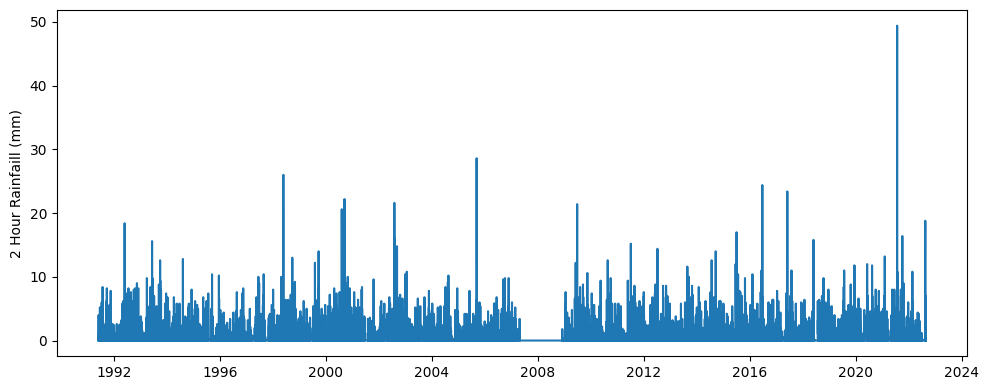

In [23]:
f, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(df_hourly.index, df_hourly['Rainfall'])

ax.set_ylabel('2 Hour Rainfaill (mm)')

plt.tight_layout()

In [24]:
(
    df_hourly
    .reset_index()
    .assign(Date=lambda x: x['Timestamp'].dt.date)
    .set_index(keys=['Date', 'Timestamp'])
    .sort_values(by='Rainfall', ascending=False)
    .head(10)
)

,,Rainfall
Date,Timestamp,
2021-07-25,2021-07-25 14:00:00+00:00,49.4
2005-09-10,2005-09-10 14:00:00+00:00,28.6
1998-05-26,1998-05-26 14:00:00+00:00,26.0
2016-06-23,2016-06-23 00:00:00+00:00,24.4
2017-06-02,2017-06-02 14:00:00+00:00,23.4
2000-09-15,2000-09-15 12:00:00+00:00,22.2
2002-08-03,2002-08-03 16:00:00+00:00,21.6
2009-06-27,2009-06-27 16:00:00+00:00,21.4
2000-08-08,2000-08-08 10:00:00+00:00,20.6


In [25]:
# No events are censored
df_hourly['Observed'] = 1

obs = df_hourly['Rainfall'].values
event = df_hourly['Observed'].values

Text(0.5, 0, '2 Hour Rainfall (mm)')

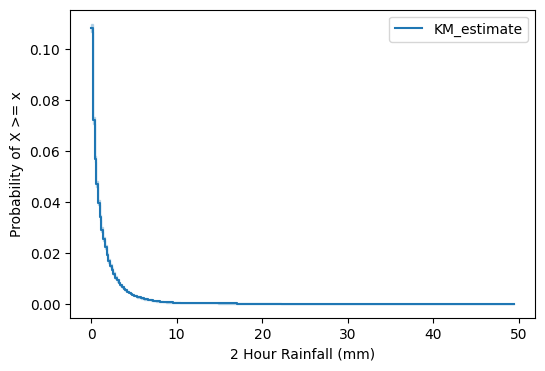

In [26]:
kmf = KaplanMeierFitter().fit(obs, event)

f, ax = plt.subplots(1, 1, figsize=(6, 4))

kmf.plot_survival_function(ax=ax)

ax.set_ylabel('Probability of X >= x')
ax.set_xlabel('2 Hour Rainfall (mm)')

Text(0.5, 0, '2 Hour Rainfall (mm)')

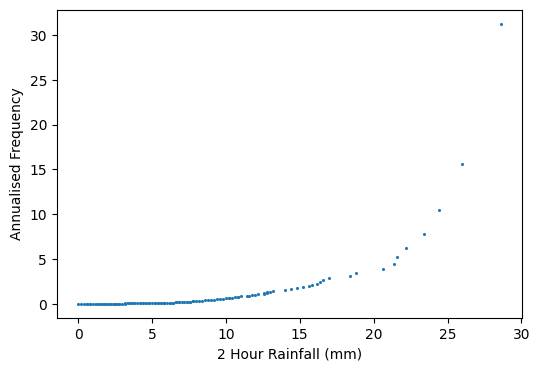

In [27]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))

surv_freq = (
    kmf.survival_function_
    .reset_index()
    .assign(
        test=1,
        freq=lambda x: (x['KM_estimate'] ** (-1)) / (365 * (24/2))
    )
    .replace({numpy.inf: numpy.nan})
    .dropna()
)

surv_freq.plot(
    ax=ax,
    kind='scatter',
    x='timeline',
    y='freq',
    s=1.5)

ax.set_ylabel('Annualised Frequency')
ax.set_xlabel('2 Hour Rainfall (mm)')